In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import math

from scipy.constants import g

In [2]:
WIDTH = 1600
HEIGHT = 1000

AIRCRAFT_SIZE = 24
COLLISION_RADIUS = 2 * AIRCRAFT_SIZE
GOAL_RADIUS = 6 * AIRCRAFT_SIZE
SAFE_DISTANCE = 4 * COLLISION_RADIUS

PLAYER_X = COLLISION_RADIUS
PLAYER_Y = HEIGHT / 2

GOAL_X = WIDTH - GOAL_RADIUS
GOAL_Y = HEIGHT / 2

# KINEMATICS CONSTANTS
AIRSPEED = 200
ACC_LAT_LIMIT = 20 * g

In [3]:
# Load simulation data
simulation_data_file = "../gym_ACAS2D/models/logs/testing_ACAS2D_PPO_1048576_11_100.csv"
simulation = pd.read_csv(simulation_data_file)

# Convert list records
simulation["Path"] = simulation.apply(lambda row: ast.literal_eval(row["Path"]), axis=1)
simulation["Traffic Paths"] = simulation.apply(lambda row: ast.literal_eval(row["Traffic Paths"]), axis=1)
simulation["psi"] = simulation.apply(lambda row: ast.literal_eval(row["psi"]), axis=1)
simulation["d_sep"] = simulation.apply(lambda row: ast.literal_eval(row["d_sep"]), axis=1)
simulation["a_lat"] = simulation.apply(lambda row: ast.literal_eval(row["a_lat"]), axis=1)
simulation["d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["d_goal"]), axis=1)
simulation["delta_heading"] = simulation.apply(lambda row: ast.literal_eval(row["delta_heading"]), axis=1)
simulation["v_closing"] = simulation.apply(lambda row: ast.literal_eval(row["v_closing"]), axis=1)
simulation["d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["d_cpa"]), axis=1)
simulation["d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["d_dev"]), axis=1)
simulation["r_d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_goal"]), axis=1)
simulation["r_h_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_h_goal"]), axis=1)
simulation["r_d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_cpa"]), axis=1)
simulation["r_d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_dev"]), axis=1)
simulation["r_step"] = simulation.apply(lambda row: ast.literal_eval(row["r_step"]), axis=1)

# Confirm that all list records have the right length, equal to the TIME_STEPS of the corresponding episode
for index, row in simulation.iterrows():
    assert len(row["Path"]) == len(row["Traffic Paths"][0]) == \
           len(row["psi"]) == len(row["a_lat"]) == \
           len(row["d_sep"]) == len(row["d_goal"]) == \
           len(row["delta_heading"]) == len(row["v_closing"]) ==\
           len(row["d_cpa"]) == len(row["d_dev"]) == row["Time Steps"] == \
           len(row["r_d_goal"]) == len(row["r_h_goal"]) == \
           len(row["r_d_cpa"]) == len(row["r_d_dev"]) ==\
           len(row["r_step"]) == \
           row["Time Steps"]

simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        100 non-null    int64  
 1   Outcome        100 non-null    object 
 2   Total Reward   100 non-null    float64
 3   Time Steps     100 non-null    int64  
 4   Path Length    100 non-null    float64
 5   Path           100 non-null    object 
 6   Traffic Paths  100 non-null    object 
 7   psi            100 non-null    object 
 8   d_sep          100 non-null    object 
 9   a_lat          100 non-null    object 
 10  d_goal         100 non-null    object 
 11  delta_heading  100 non-null    object 
 12  v_closing      100 non-null    object 
 13  d_cpa          100 non-null    object 
 14  d_dev          100 non-null    object 
 15  r_d_goal       100 non-null    object 
 16  r_h_goal       100 non-null    object 
 17  r_d_cpa        100 non-null    object 
 18  r_d_dev    

In [4]:
simulation.head()

,Episode,Outcome,Total Reward,Time Steps,Path Length,Path,Traffic Paths,psi,d_sep,a_lat,d_goal,delta_heading,v_closing,d_cpa,d_dev,r_d_goal,r_h_goal,r_d_cpa,r_d_dev,r_step
0,1,Goal,1185.186205,690,1378.0,"[(48, 500.0), (49.99933588666059, 500.05153651...","[[(1552, 48), (1552, 48), (1550.2682011548015,...","[2.4572408207095524, 1.4765758207095525, 0.544...","[1570.4521641871172, 1568.5523856925836, 1564....","[0, -196.13299999999998, -186.3592094825506, -...","[1408.0, 1406.0006650578666, 1404.000756291214...","[2.4572408207095524, 1.4786759795765079, 0.547...","[-383.5366558358088, -384.6435181346255, -385....","[-80.78427185117448, -67.35947211135499, -54.6...","[0.0, -0.051536514348675906, -0.07055262930141...","[0.11861009077374525, 0.11908508503310593, 0.1...","[0.9465026611158013, 0.9675432250469196, 0.987...","[0.03134024191536947, 0.01514920299798381, 0.0...","[1.0, 0.9999633966920672, 0.9999498903430186, ...","[0.029663622372910183, 0.014627658267829802, 0..."
1,2,Goal,1323.789062,639,1276.0,"[(48, 500.0), (49.99822588436693, 499.91577817...","[[(1552, 48), (1552, 48), (1550.5512416758345,...","[358.1242450086868, 357.5865088940248, 357.084...","[1570.4521641871172, 1568.5143289157752, 1564....","[0, -107.54722293239831, -100.44295557558536, ...","[1408.0, 1406.0017766381459, 1404.004375527865...","[1.8757549913132152, 2.4169232174702415, 2.923...","[-371.73857922701563, -372.2041020963558, -372...","[164.21322359081498, 171.54054510790007, 178.3...","[0.0, 0.0842218204860501, 0.18595523350330723,...","[0.11861009077374525, 0.11908482055245495, 0.1...","[0.9589636070267364, 0.9473627067654035, 0.936...","[0.5350909324946604, 0.6371801362280624, 0.744...","[1.0, 0.9999401815770101, 0.999867920799202, 0...","[0.5131327307123795, 0.6023973805400866, 0.695..."
2,3,Goal,1157.812210,720,1438.0,"[(48, 500.0), (49.996836776887854, 499.8875594...","[[(1552, 48), (1552, 48), (1550.186920830651, ...","[357.75778005291477, 356.7771150529148, 355.79...","[1570.4521641871172, 1568.5075290482362, 1564....","[0, -196.13299999999998, -196.13299999999998, ...","[1408.0, 1406.0031677191498, 1404.008567244498...","[2.242219947085232, 3.227466993168605, 4.21412...","[-391.5743382598032, -392.4089008873426, -393....","[-85.52517294258713, -72.10235087229375, -58.7...","[0.0, 0.11244059083855971, 0.25904056856177243...","[0.11861009077374525, 0.11908448957022504, 0.1...","[0.9510962102369062, 0.9301845457711637, 0.909...","[0.039370499918633416, 0.01988807664876798, 0....","[1.0, 0.9999201384368902, 0.9998160053964577, ...","[0.037445133267744665, 0.018461107930020773, 0..."
3,4,Goal,1138.713748,780,1558.0,"[(48, 500.0), (49.99976530148179, 500.03063884...","[[(1552, 952), (1552, 952), (1550.521736758849...","[1.8584376672663634, 0.8777726672663635, 359.8...","[1570.4521641871172, 1568.528293801169, 1564.8...","[0, -196.13299999999998, -195.7528503438234, -...","[1408.0, 1406.0002350323514, 1404.000238067206...","[1.8584376672663634, 0.8790212279847083, 0.099...","[-373.6387476900785, -372.7176275103341, -371....","[-147.0632072158358, -133.6772444176431, -120....","[0.0, -0.030638847717185322, -0.02711357821150...","[0.11861009077374525, 0.11908518735010598, 0.1...","[0.9593365850107883, 0.9806088182359795, 0.997...","[0.3442002783847647, 0.23497682072745582, 0.15...","[1.0, 0.9999782392179806, 0.9999807430118771, ...","[0.3302039196254028, 0.22995449770283324, 0.15..."
4,5,Goal,1171.120797,706,1410.0,"[(48, 500.0), (49.99818608383937, 499.91483912...","[[(1552, 48), (1552, 48), (1550.223564852914, ...","[358.5402478585722, 357.5595828585722, 356.578...","[1570.4521641871172, 1568.5140964716568, 1564....","[0, -196.13299999999998, -196.13299999999998, ...","[1408.0, 1406.001816495238, 1404.0053929337453...","[1.4597521414278276, 2.4438875200352186, 3.429...","[-389.512329530738, -390.39347724111303, -391....","[-63.63803970374003, -50.207113587578334, -36....","[0.0, 0.08516087335556223, 0.20450822270362323...","[0.11861009077374525, 0.119

In [5]:
simulation.describe()

,Episode,Total Reward,Time Steps,Path Length
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,1210.069219,704.350000,1406.700000
std,29.011492,69.336537,73.826082,147.652164
min,1.000000,1099.788122,634.000000,1266.000000
25%,25.750000,1157.389870,656.000000,1310.000000
50%,50.500000,1200.470752,681.000000,1360.000000
75%,75.250000,1245.515314,721.000000,1440.000000
max,100.000000,1370.264607,927.000000,1852.000000


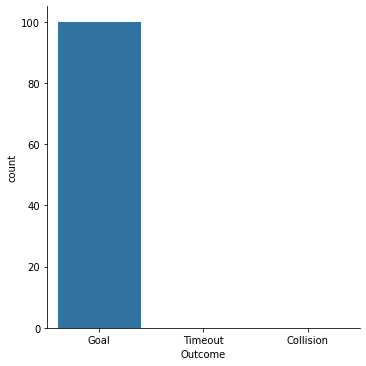

In [6]:
sns.catplot(x="Outcome", data=simulation, order=["Goal", "Timeout", "Collision"], kind="count")

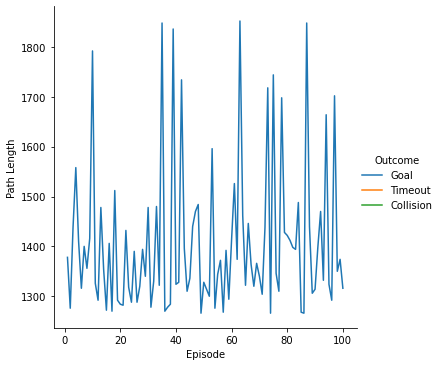

In [7]:
sns.relplot(x="Episode", y="Path Length", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Timeout", "Collision"],)

<AxesSubplot:xlabel='Outcome', ylabel='Path Length'>

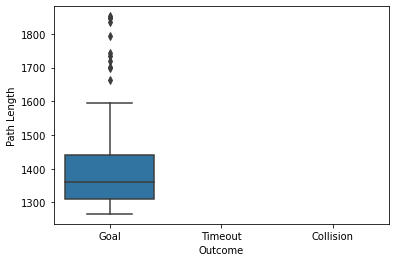

In [8]:
sns.boxplot(x="Outcome", y="Path Length", data=simulation, order=["Goal", "Timeout", "Collision"])

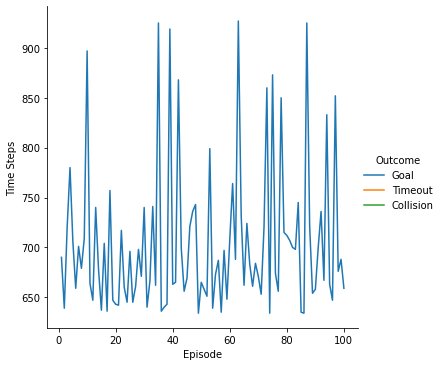

In [9]:
sns.relplot(x="Episode", y="Time Steps", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Timeout", "Collision"],)

<AxesSubplot:xlabel='Outcome', ylabel='Time Steps'>

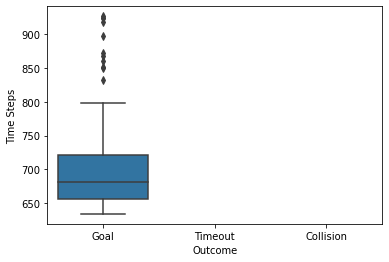

In [10]:
sns.boxplot(x="Outcome", y="Time Steps", data=simulation, order=["Goal", "Timeout", "Collision"])

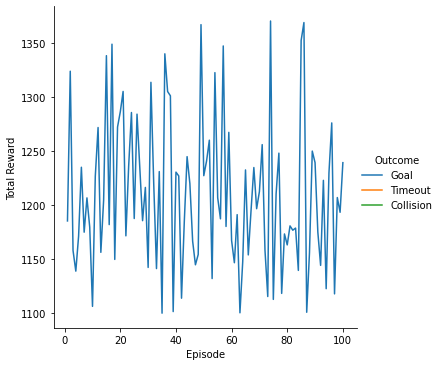

In [11]:
sns.relplot(x="Episode", y="Total Reward", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Timeout", "Collision"])

<AxesSubplot:xlabel='Outcome', ylabel='Total Reward'>

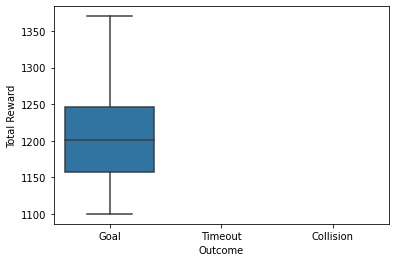

In [12]:
sns.boxplot(x="Outcome", y="Total Reward", data=simulation, order=["Goal", "Timeout", "Collision"])

In [13]:
# Create detailed dataframe

"""
#   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        10 non-null     int64  
 1   Outcome        10 non-null     object 
 2   Total Reward   10 non-null     float64
 3   Time Steps     10 non-null     int64  
 4   Path Length    10 non-null     float64
 5   Path           10 non-null     object 
 6   Traffic Paths  10 non-null     object 
 7   psi            10 non-null     object 
 8   d_sep          10 non-null     object 
 9   a_lat          10 non-null     object 
 10  d_goal         10 non-null     object 
 11  delta_heading  10 non-null     object 
 12  v_closing      10 non-null     object 
 13  d_cpa          10 non-null     object 
 14  d_dev          10 non-null     object 
 15  r_d_goal       10 non-null     object 
 16  r_h_goal       10 non-null     object 
 17  r_d_cpa        10 non-null     object 
 18  r_d_dev        10 non-null     object 
 19  r_step         10 non-null     object 
"""

sim = pd.DataFrame()

e_values, o_values, t_values, l_values, tr_values = [], [], [], [], []
x_values, y_values, tx_values, ty_values = [], [], [], []
psi_values, d_sep_values, a_lat_values, d_goal_values,  = [], [], [], []
delta_heading_values, v_closing_values, d_cpa_values, d_dev_values  = [], [], [], []
r_d_goal_values, r_h_goal_values, r_d_cpa_values, r_d_dev_values, r_step_values = [], [], [], [], []

for index, row in simulation.iterrows():
        e_values += [row["Episode"]] * row["Time Steps"]
        o_values += [row["Outcome"]] * row["Time Steps"]
        t_values += list(range(1, row["Time Steps"]+1))
        l_values += [row["Path Length"]] * row["Time Steps"]
        tr_values += [row["Total Reward"]] * row["Time Steps"]
        x_values += [pos[0] for pos in row["Path"]]
        y_values += [-pos[1] for pos in row["Path"]]
        tx_values += [pos[0] for pos in row["Traffic Paths"][0]]
        ty_values += [-pos[1] for pos in row["Traffic Paths"][0]]
        psi_values += row["psi"]
        d_sep_values += row["d_sep"]
        a_lat_values += row["a_lat"]
        d_goal_values += row["d_goal"]
        delta_heading_values += row["delta_heading"]
        v_closing_values += row["v_closing"]
        d_cpa_values += row["d_cpa"]
        d_dev_values += row["d_dev"]
        r_d_goal_values += row["r_d_goal"]
        r_h_goal_values += row["r_h_goal"]
        r_d_cpa_values += row["r_d_cpa"]
        r_d_dev_values += row["r_d_dev"]
        r_step_values += row["r_step"]
        
sim["Episode"] = e_values
sim["Outcome"] = o_values
sim["Time Steps"] = t_values
sim["Path Length"] = l_values
sim["Total Reward"] = tr_values
sim["x"] = x_values
sim["y"] = y_values
sim["tx"] = tx_values
sim["ty"] = ty_values
sim["psi"] = psi_values
sim["d_sep"] = d_sep_values
sim["a_lat"] = a_lat_values
sim["a_lat_norm"] = sim["a_lat"] / ACC_LAT_LIMIT
sim["d_goal"] = d_goal_values
sim["delta_heading"] = delta_heading_values
sim["v_closing"] = v_closing_values
sim["v_closing_positive"] = sim.apply(lambda row: row["v_closing"] > 0, axis=1)
sim["d_cpa"] = d_cpa_values
sim["d_dev"] = d_dev_values
sim["r_d_goal"] = r_d_goal_values
sim["r_h_goal"] = r_h_goal_values
sim["r_d_cpa"] = r_d_cpa_values
sim["r_d_dev"] = r_d_dev_values
sim["r_step"] = r_step_values

sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70435 entries, 0 to 70434
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Episode             70435 non-null  int64  
 1   Outcome             70435 non-null  object 
 2   Time Steps          70435 non-null  int64  
 3   Path Length         70435 non-null  float64
 4   Total Reward        70435 non-null  float64
 5   x                   70435 non-null  float64
 6   y                   70435 non-null  float64
 7   tx                  70435 non-null  float64
 8   ty                  70435 non-null  float64
 9   psi                 70435 non-null  float64
 10  d_sep               70435 non-null  float64
 11  a_lat               70435 non-null  float64
 12  a_lat_norm          70435 non-null  float64
 13  d_goal              70435 non-null  float64
 14  delta_heading       70435 non-null  float64
 15  v_closing           70435 non-null  float64
 16  v_cl

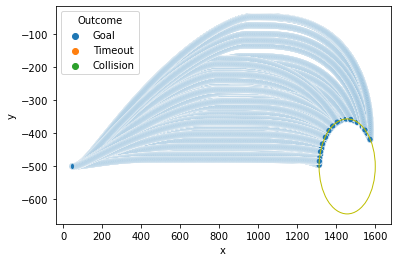

In [14]:
fig, ax = plt.subplots()

sns.scatterplot(x="x", y="y", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

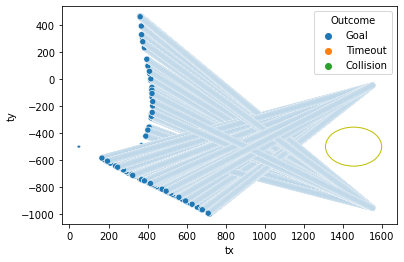

In [15]:
fig, ax = plt.subplots()

sns.scatterplot(x="tx", y="ty", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

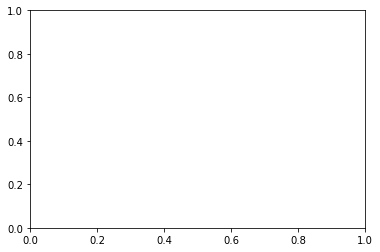

In [16]:
fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=sim[sim["Outcome"]=="Timeout"], ax=ax)
sns.scatterplot(x="tx", y="ty", data=sim[sim["Outcome"]=="Timeout"], ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

<AxesSubplot:xlabel='Time Steps', ylabel='r_step'>

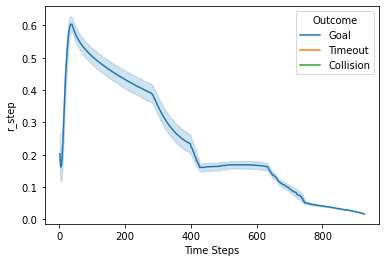

In [17]:
fig, ax = plt.subplots()

# # Ignore high terminal rewards 
# plt.ylim(0, 1)

sns.lineplot(x="Time Steps", y="r_step", data=sim, ax=ax, 
             hue="Outcome", hue_order=["Goal", "Timeout", "Collision"])

<AxesSubplot:xlabel='Time Steps', ylabel='delta_heading'>

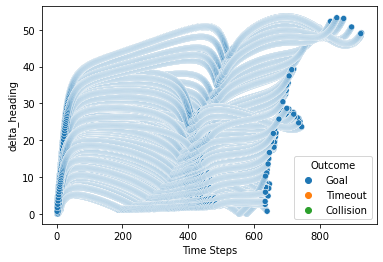

In [18]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="delta_heading", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

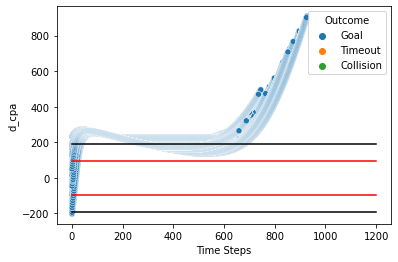

In [19]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_cpa", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

saf = plt.Line2D([0, 1200], [SAFE_DISTANCE, SAFE_DISTANCE], color="black")
ax.add_line(saf)
col = plt.Line2D([0, 1200], [2*COLLISION_RADIUS, 2*COLLISION_RADIUS], color="red")
ax.add_line(col)
safn = plt.Line2D([0, 1200], [-SAFE_DISTANCE, -SAFE_DISTANCE], color="black")
ax.add_line(safn)
coln = plt.Line2D([0, 1200], [-2*COLLISION_RADIUS, -2*COLLISION_RADIUS], color="red")
ax.add_line(coln)

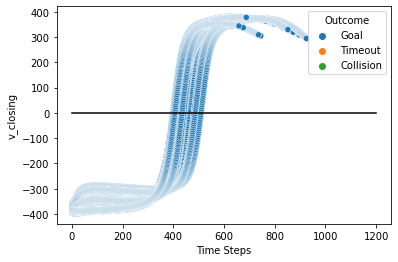

In [20]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="v_closing", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

resolution = plt.Line2D([0, 1200], [0, 0], color="black")
ax.add_line(resolution)

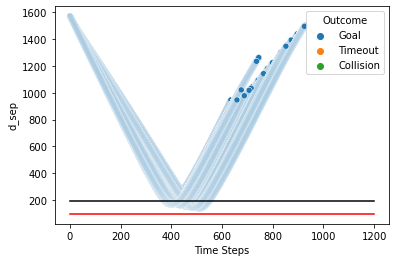

In [21]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_sep", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

saf = plt.Line2D([0, 1200], [SAFE_DISTANCE, SAFE_DISTANCE], color="black")
ax.add_line(saf)
col = plt.Line2D([0, 1200], [2*COLLISION_RADIUS, 2*COLLISION_RADIUS], color="red")
ax.add_line(col)

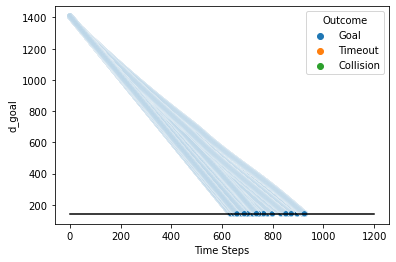

In [22]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_goal", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

goal = plt.Line2D([0, 1200], [GOAL_RADIUS, GOAL_RADIUS], color="black")
ax.add_line(goal)

<AxesSubplot:xlabel='Time Steps', ylabel='a_lat_norm'>

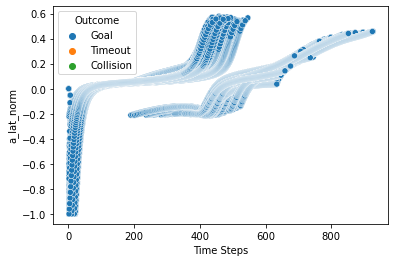

In [23]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="a_lat_norm", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Timeout", "Collision"])

In [24]:
# a_lats = sim[sim["Episode"]==1]["a_lat"]
 
# actions = [x/ACC_LAT_LIMIT for x in a_lats]

# print(actions)